# Modelling

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [54]:
# Load final dataset
# final_df = pd.read_csv('../data/processed/final/final_data.csv')
final_df_stable = pd.read_csv('../data/processed/final/final_data_stable.csv')

# Check feature distribution and handle missing values
print(f"Feature dataset shape: {final_df_stable.shape}")
print(f"Missing values: {final_df_stable.isnull().sum().sum()}")

# Fill missing values with median
final_df_stable = final_df_stable.fillna(final_df_stable.median())

# Prepare features and target
X = final_df_stable.drop(['point_id', 'point_lon', 'point_lat', 'is_damaged'], axis=1)
y = final_df_stable['is_damaged']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in testing: {np.bincount(y_test)}")

Feature dataset shape: (8448, 100)
Missing values: 108870
Training set: 5913 samples
Testing set: 2535 samples
Class distribution in training: [2956 2957]
Class distribution in testing: [1268 1267]


/var/folders/r4/hzh5vjhs64sfqz3fgg0md4x80000gn/T/ipykernel_18822/3218061794.py:23: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print(f"Class distribution in training: {np.bincount(y_train)}")
/var/folders/r4/hzh5vjhs64sfqz3fgg0md4x80000gn/T/ipykernel_18822/3218061794.py:24: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print(f"Class distribution in testing: {np.bincount(y_test)}")


## Random forest classifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 5. Define hyperparameters for random search
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [56]:
# Cross-validation and grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_grid, 
    n_iter=20,  # Sample combinations
    cv=cv, 
    scoring='f1', 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [None, 10, 20],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 200]},
                   random_state=42, scoring='f1', verbose=1)

In [57]:
# Print best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

Best parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': None}
Best cross-validation score: 0.6626


In [58]:
# Save the model
import joblib

# Save the best model
joblib.dump(random_search.best_estimator_, '../results/models/best_random_forest.pkl')
print("Model saved successfully.")

# To load the model later
# loaded_model = joblib.load('../results/models/best_random_forest.pkl')

Model saved successfully.



Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.71      0.68      1268
         1.0       0.68      0.64      0.66      1267

    accuracy                           0.67      2535
   macro avg       0.67      0.67      0.67      2535
weighted avg       0.67      0.67      0.67      2535



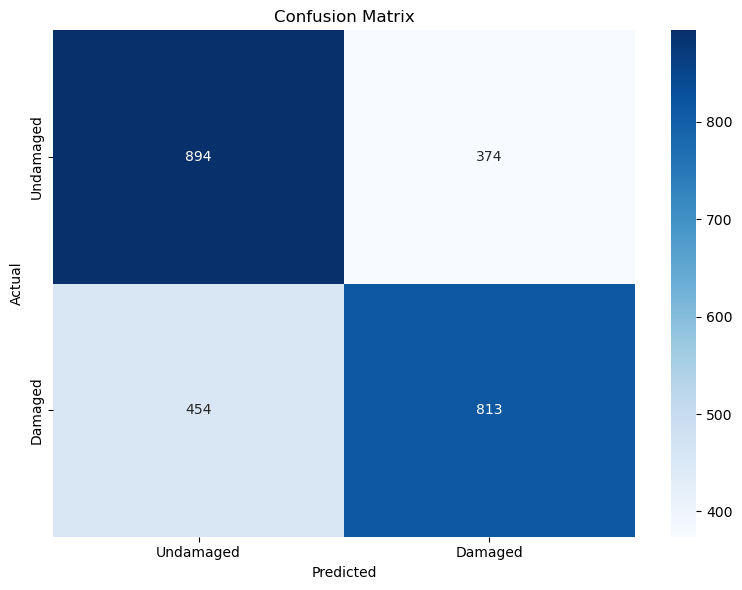

In [59]:
# Evaluate the model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 10. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Undamaged', 'Damaged'],
            yticklabels=['Undamaged', 'Damaged'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

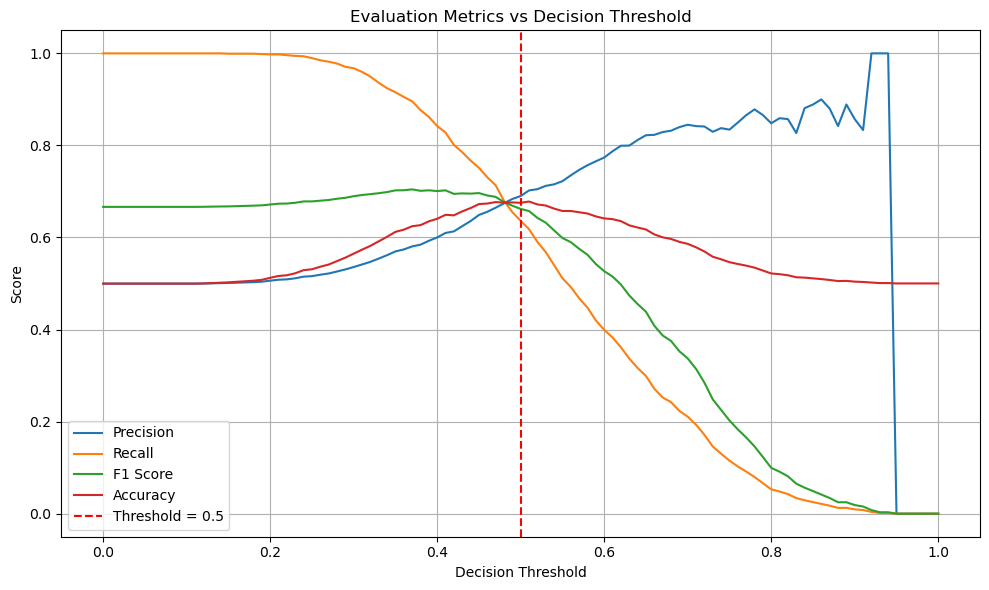

In [51]:
# Define thresholds to evaluate
thresholds = np.linspace(0, 1, 101)

# Store metrics
precisions = []
recalls = []
f1s = []
accuracies = []

# Calculate metrics for each threshold
for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))
    accuracies.append(accuracy_score(y_test, y_pred_thresh))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, accuracies, label='Accuracy')
# Add vertical line 0.5 threshold
plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs Decision Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Neural networks

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/envs/ML-summative/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/ML-summative/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/ML-summative/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/ML-summative/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.wa


Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.65      0.64      1268
         1.0       0.63      0.62      0.63      1267

    accuracy                           0.63      2535
   macro avg       0.63      0.63      0.63      2535
weighted avg       0.63      0.63      0.63      2535



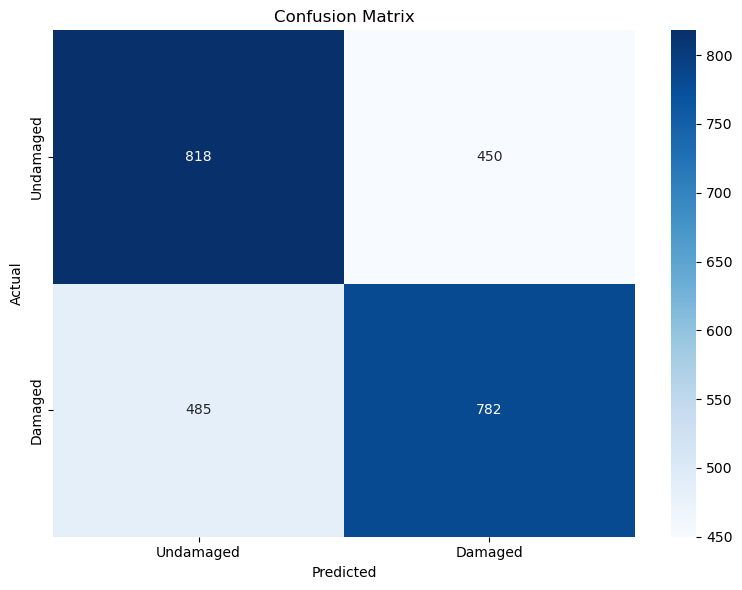

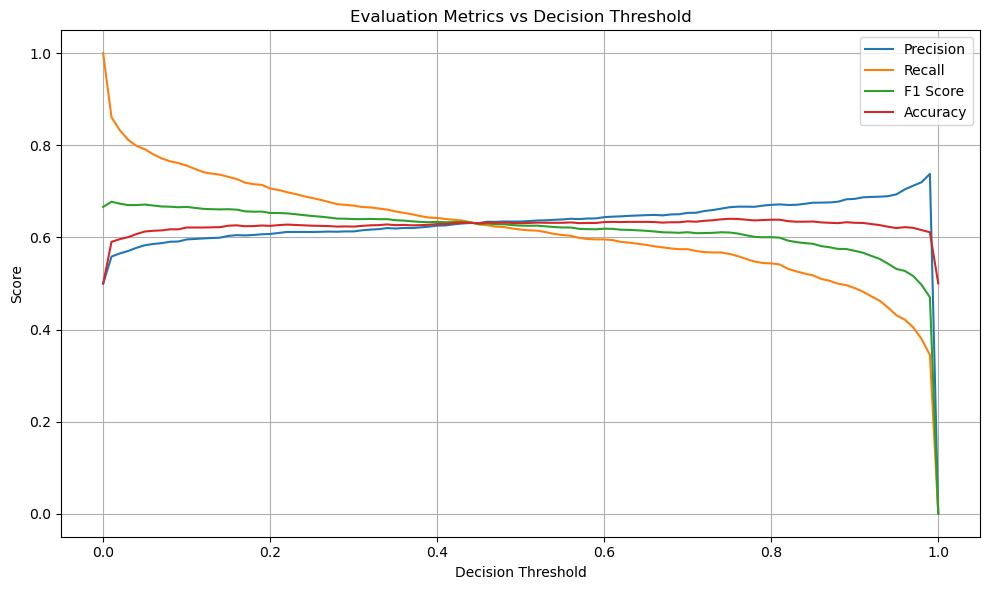

In [37]:
from sklearn.neural_network import MLPClassifier
import random

def generate_layer_sizes():
    # Randomly choose number of hidden layers (1 to 3 layers)
    n_layers = random.choice([1, 2, 3])
    # For each layer, randomly choose number of neurons (e.g., 20–200)
    return tuple(random.randint(20, 200) for _ in range(n_layers))

# 2. Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Neural networks benefit a lot from scaling!
    ('classifier', MLPClassifier(random_state=42, max_iter=500))
])

# 3. Define hyperparameters to search
param_distributions = {
    'classifier__hidden_layer_sizes': [generate_layer_sizes() for _ in range(10)],  # 10 random architectures
    'classifier__activation': ['relu', 'tanh'],
    'classifier__alpha': [1e-5, 1e-4, 1e-3],  # L2 penalty
    'classifier__learning_rate_init': [0.001, 0.01],
}

# 4. Random search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions,
    n_iter=10, 
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 5. Train
random_search.fit(X_train, y_train)

# 6. Save the best model
joblib.dump(random_search.best_estimator_, '../results/models/best_mlp.pkl')

# 7. Predict
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 8. Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Undamaged', 'Damaged'],
            yticklabels=['Undamaged', 'Damaged'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 9. Plot metrics vs threshold (optional but recommended)
thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []
f1s = []
accuracies = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))
    accuracies.append(accuracy_score(y_test, y_pred_thresh))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs Decision Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()